## The source code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
reproduction_distribution = np.array([0, 0.3, 0.7])
maximum_reproduction = len(reproduction_distribution) - 1
mu = np.sum([i * reproduction_distribution[i] for i in range(maximum_reproduction + 1)])
price_to_cost_treshold = 1 / (1 - 1 / mu)
price_to_cost_treshold

2.428571428571429

In [3]:
def reward(population, sell):
    if population == 0:
        return sell_the_farm
    else:
        return price * sell - cost * population

In [3]:
def get_exact_pmfs():
    maximum_remaining_population = capacity
    exact_pmfs = [np.array([1])]
    current_population = 1
    while current_population <= maximum_remaining_population:
        maximum_next_gen_population = np.min([maximum_reproduction * current_population, capacity])
        previous_pmf = np.hstack((exact_pmfs[-1], np.zeros(maximum_reproduction)))
        new_pmf = np.zeros(len(previous_pmf))
        
        for i in range(maximum_reproduction + 1):
            new_pmf += previous_pmf * reproduction_distribution[i]
            previous_pmf = np.roll(previous_pmf, 1)
        
        new_truncated_pmf = np.zeros(maximum_next_gen_population + 1)
        new_truncated_pmf[:-1] += new_pmf[:maximum_next_gen_population]
        new_truncated_pmf[-1] += np.sum(new_pmf[maximum_next_gen_population:])
        current_population += 1
        exact_pmfs.append(new_truncated_pmf)
    return exact_pmfs

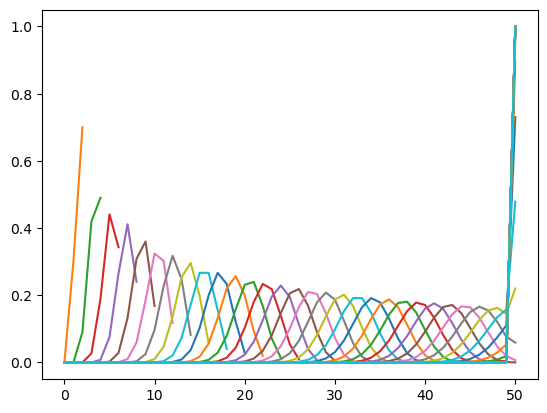

In [21]:
capacity = 50
pmfs = get_exact_pmfs()
for i in range(capacity):
    plt.plot(pmfs[i])

In [12]:
len(get_exact_pmfs())

21

In [5]:
def exact_Bellman_operator(V):
    new_V = []
    optimal_sell = []
    Qs = []
    for population in range(capacity + 1):
        Q = []
        lower_bound = 0
        for sell in range(lower_bound, population + 1):
            
            remaining_population = population - sell
            pmf = pmfs[remaining_population]
            expected_V = 0
            for next_gen_population in range(len(pmf)):
                expected_V += pmf[next_gen_population] * V[next_gen_population] 
            
            Q.append(reward(population, sell) + discount * expected_V)
            
        new_V.append(np.max(Q))
        optimal_sell.append(np.argmax(Q) + lower_bound)
        Qs.append(Q)
        
    return new_V, optimal_sell, Qs

In [6]:
def exact_iterative_method(iterations, my_discount):
    plt.figure(figsize = (15, 6))
    value_axs = plt.subplot(1, 2, 1)
    sell_axs = plt.subplot(1, 2, 2)
    
    value_axs.set_title('the value function through the iterations', fontsize = 18)
    value_axs.set_xlabel('population', fontsize = 18)
    value_axs.set_ylabel('value', fontsize = 18)
    
    sell_axs.set_title('the optimall sell', fontsize = 18)
    sell_axs.set_xlabel('population', fontsize = 18)
    sell_axs.set_ylabel('sell', fontsize = 18)
    
    V = np.zeros(capacity + 1)
    global pmfs, discount
    discount = my_discount
    pmfs = get_exact_pmfs()
    value_axs.plot(V)
    for i in tqdm(range(iterations)):
        result = exact_Bellman_operator(V)
        V = result[0]
        value_axs.plot(V)
    no_overflow_lower_bound = [np.max([population - int(capacity / maximum_reproduction), 0]) for population in range(capacity + 1)]
    sell_axs.plot(result[1], color = 'red', label = 'optimal sell')
    sell_axs.plot(no_overflow_lower_bound, '--', color = 'blue', label = 'no overflow lower bound')
    sell_axs.plot(np.arange(capacity + 1), '--', color = 'green', label = 'upper bound')
    plt.legend()
    plt.savefig('./images/finite_capacity_with_sparing_the_overflow_exact,capacity=%i,discount=0%d.png' %(capacity, int(my_discount * 1000)))

## Tests:

In [7]:
price = 6
cost = 1
sell_the_farm = 0
gamma_treshold = 1 / (mu * (1 - (cost / price)))
gamma_treshold

0.7058823529411764

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


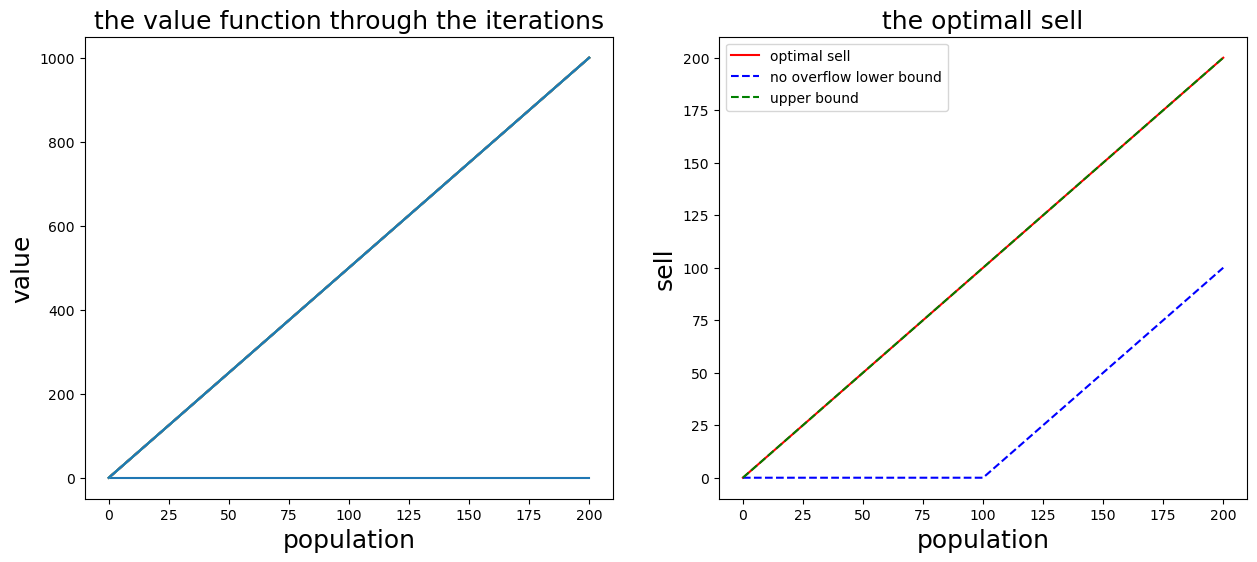

In [8]:
capacity = 200
exact_iterative_method(10, 0.65)

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


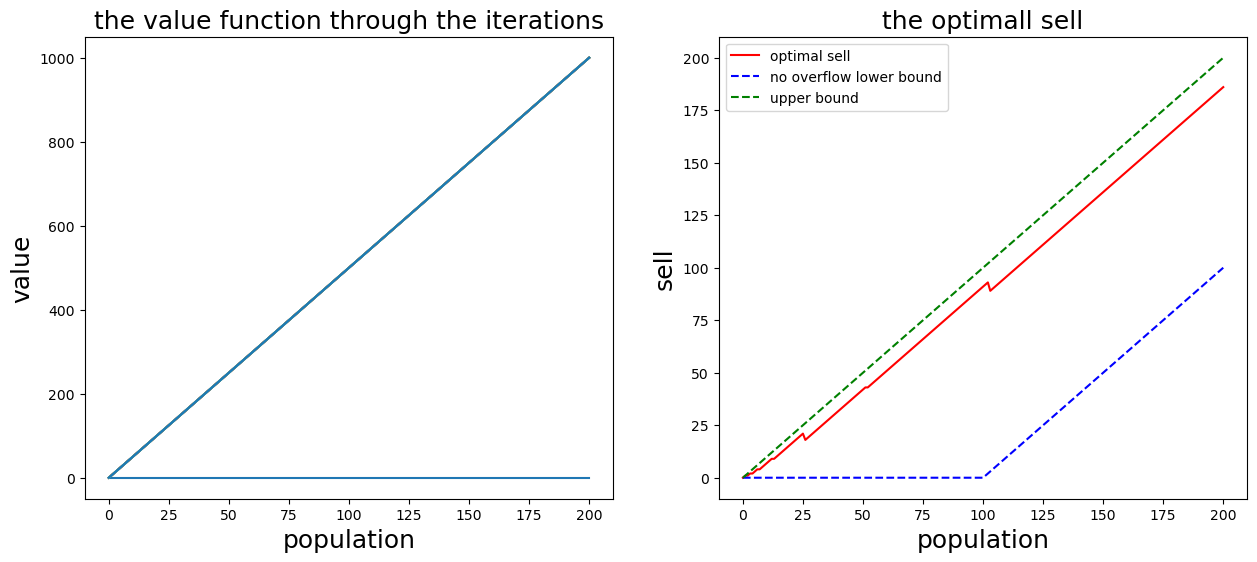

In [9]:
capacity = 200
exact_iterative_method(10, gamma_treshold)

100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


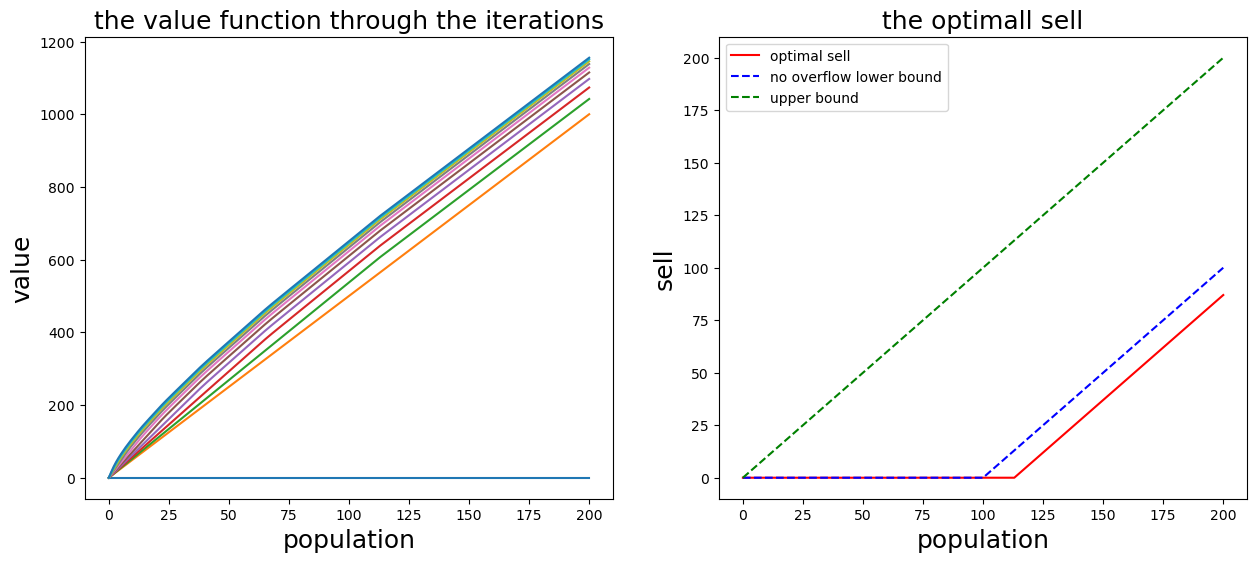

In [10]:
capacity = 200
exact_iterative_method(10, 0.75)

## Studying the selling point:

### Dependence of selling on discount:

In [8]:
def get_selling_point(my_capacity, my_discount):
    iterations = 10
    global capacity, pmfs, discount
    capacity = my_capacity
    discount = my_discount
    pmfs = get_exact_pmfs()
    
    V = np.zeros(capacity + 1)
    for i in range(iterations):
        result = exact_Bellman_operator(V)
        V = result[0]
    
    my_optimal_sell = result[1]
    selling_point = 0
    while my_optimal_sell[selling_point] == 0:
        selling_point += 1
    return selling_point - 1

100%|██████████| 99/99 [05:37<00:00,  3.41s/it]


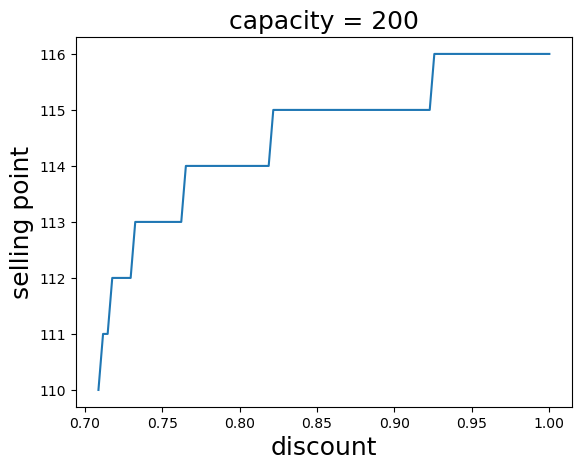

In [23]:
discounts = np.linspace(gamma_treshold, 1, 100)[1:]
plt.plot(discounts, [get_selling_point(200, discount) for discount in tqdm(discounts)])
plt.xlabel('discount', fontsize = 18)
plt.ylabel('selling point', fontsize = 18)
plt.title('capacity = 200', fontsize = 18)
plt.savefig('./images/selling_point_vs_discount')

### Dependence of selling point on the capacity:

In [9]:
def get_selling_points(lower_bound, uper_bound, number_of_points):
    my_discount = 0.85
    capacities = np.arange(lower_bound, uper_bound, int((uper_bound - lower_bound) / number_of_points))
    selling_points = []
    for capacity in tqdm(capacities):
        selling_points.append(get_selling_point(capacity, my_discount))
    return capacities, np.array(selling_points)

In [40]:
caps, sells = get_selling_points(5, 1000, 20)

100%|██████████| 21/21 [37:00<00:00, 105.75s/it]


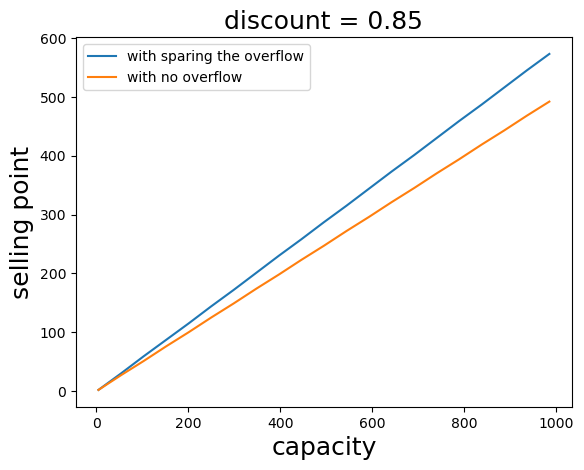

In [42]:
plt.plot(caps, sells, label = 'with sparing the overflow')
plt.plot(caps, np.floor(caps / maximum_reproduction), label = 'with no overflow')
plt.xlabel('capacity', fontsize = 18)
plt.ylabel('selling point', fontsize = 18)
plt.title('discount = 0.85', fontsize = 18)
plt.legend()
plt.savefig('./images/selling_point_vs_capacity')

## Checking the significance of our results:

### The behaviour of the state-action value function:

In [47]:
def get_state_action_value_function(my_discount):
    iterations = 10
    global capacity, discount, pmfs
    capacity = 200
    discount = my_discount
    pmfs = get_exact_pmfs()
    
    V = np.zeros(capacity + 1)
    for i in tqdm(range(iterations)):
        result = exact_Bellman_operator(V)
        V = result[0]
    
    plt.figure(figsize = (15, 6))
    below_the_selling_point_axs = plt.subplot(1, 2, 1)
    above_the_selling_point_axs = plt.subplot(1, 2, 2)
    
    below_the_selling_point_population = 50
    below_the_selling_point_sells = np.arange(below_the_selling_point_population + 1)
    below_the_selling_point_axs.plot(below_the_selling_point_sells, result[2][below_the_selling_point_population])
    below_the_selling_point_axs.set_xlabel('sell', fontsize = 18)
    below_the_selling_point_axs.set_ylabel('value', fontsize = 18)
    below_the_selling_point_axs.set_title('state-action value function\n (discount = %4.3f, population = %d)' %(my_discount, below_the_selling_point_population), fontsize = 18)
    
    above_the_selling_point_population = 150
    above_the_selling_point_sells = np.arange(above_the_selling_point_population + 1)
    above_the_selling_point_axs.plot(above_the_selling_point_sells, result[2][above_the_selling_point_population])
    above_the_selling_point_axs.set_xlabel('sell', fontsize = 18)
    above_the_selling_point_axs.set_ylabel('value', fontsize = 18)
    above_the_selling_point_axs.set_title('state-action value function\n (discount = %4.3f, population = %d)' %(my_discount, above_the_selling_point_population), fontsize = 18)

    plt.savefig('./images/state-action_value_function_with_sparing_the_overflow_discount=0%d' %int(my_discount * 1000))

### critical:

100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


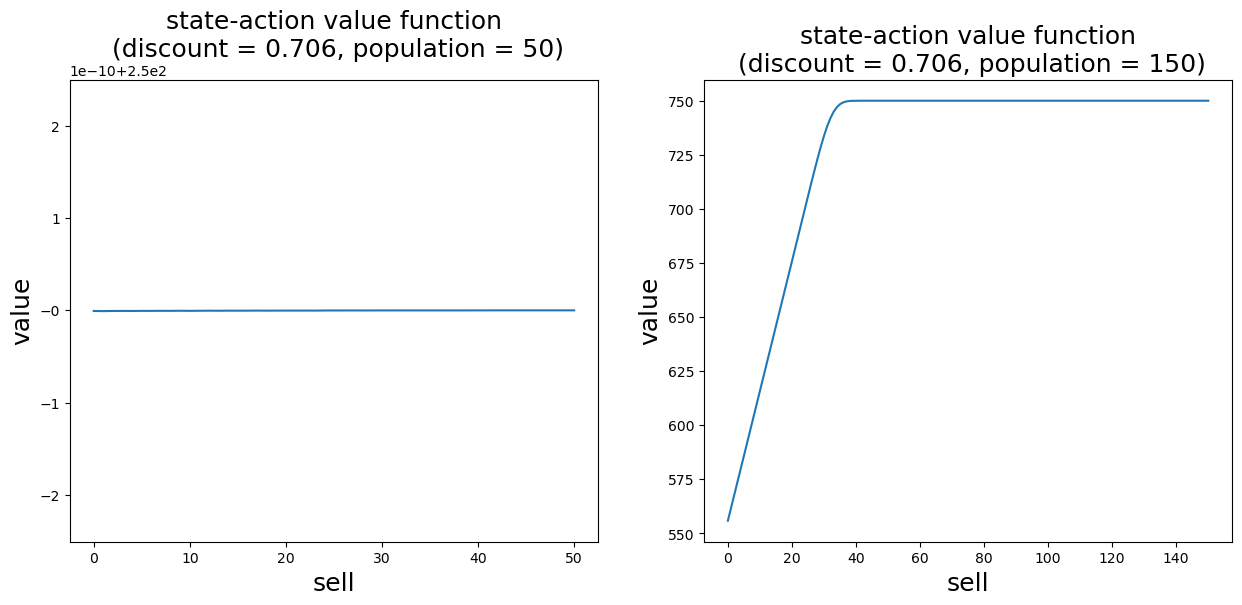

In [48]:
get_state_action_value_function(gamma_treshold)

### super-critical:

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


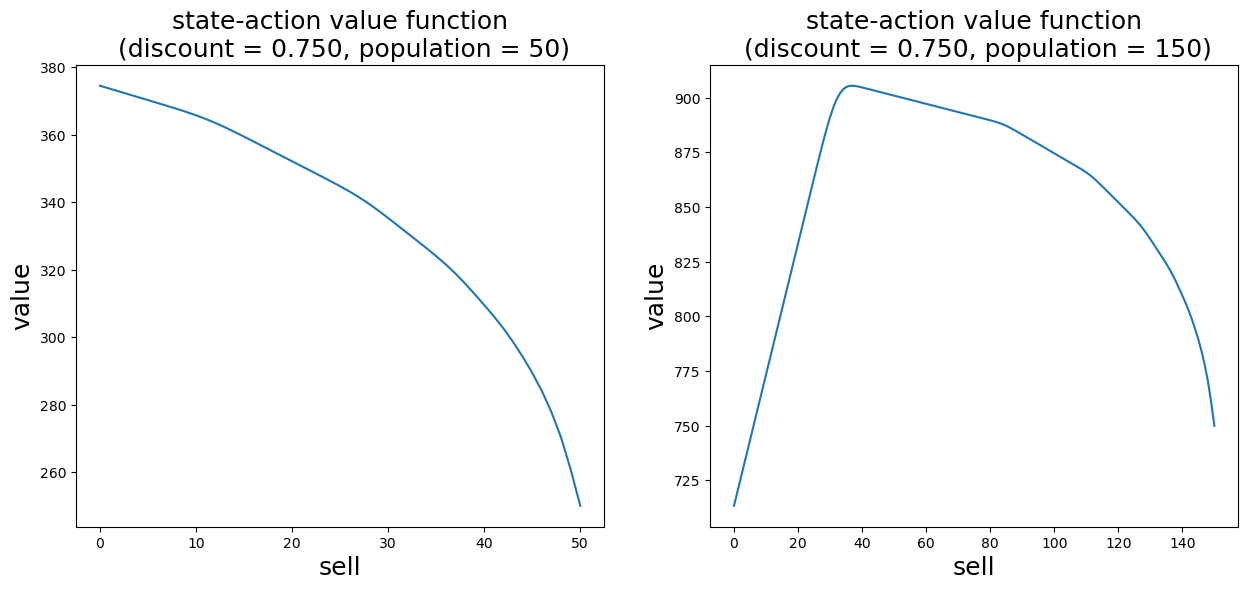

In [49]:
get_state_action_value_function(0.75)

### sub-critical:

100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


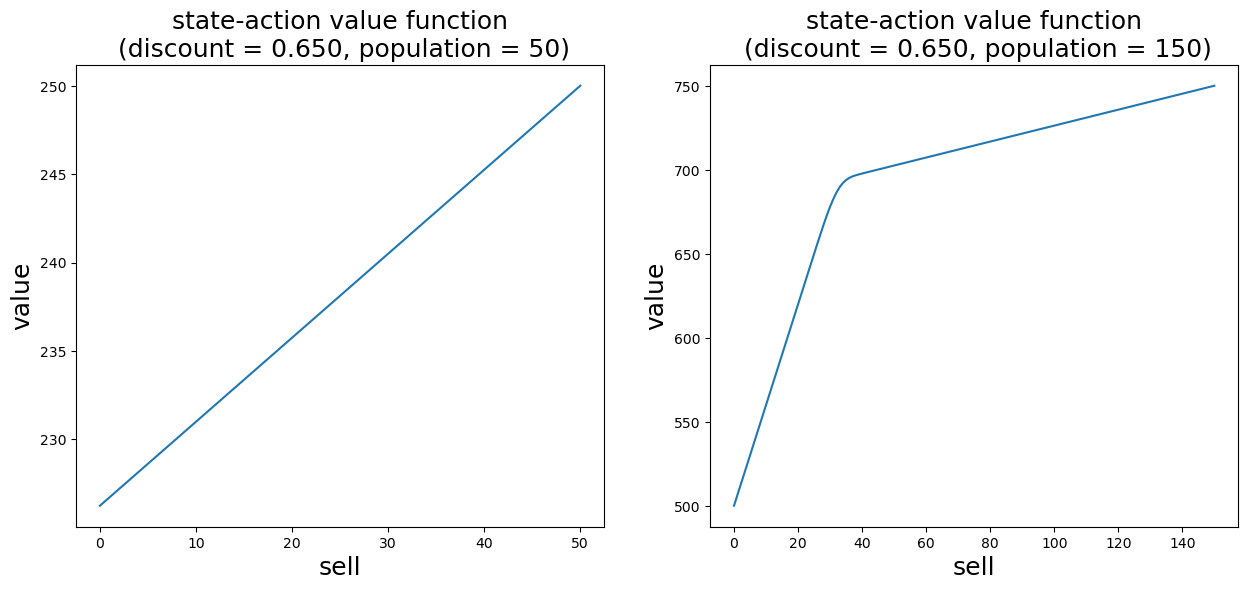

In [50]:
get_state_action_value_function(0.65)

### The siginificance of the results:

In [35]:
def significant_exact_iterative_method(iterations, my_discount):
    
    global pmfs, discount, lower_bound
    lower_bound = np.zeros(capacity + 1).astype(int)
    discount = my_discount
    pmfs = get_exact_pmfs()
    
    V = np.zeros(capacity + 1)
    for i in tqdm(range(iterations)):
        result = exact_Bellman_operator(V)
        V = result[0]
    
    exponent = 10
    tol = 10 ** (-exponent)
    appearent_optimal_sell = []
    optimal_sells_lower_bound = []
    optimal_sells_upper_bound = []
    my_Qs = result[2]
    for population in range(capacity + 1):
        population_lower_bound = lower_bound[population]
        population_Q = my_Qs[population]
        appearent_optimal_sell.append(np.argmax(population_Q) + population_lower_bound)
        appearent_maximum_value = np.max(population_Q)
        i = 0
        while (appearent_maximum_value - population_Q[i]) >= tol:
            i += 1
        optimal_sells_lower_bound.append(i + population_lower_bound)
        Q_length = len(population_Q)
        while i < Q_length and (appearent_maximum_value - population_Q[i]) < tol:
            i += 1
        optimal_sells_upper_bound.append(i - 1 + population_lower_bound)
        
    populations = np.arange(capacity + 1)
    no_overflow_lower_bound = [np.max([population - int(capacity / maximum_reproduction), 0]) for population in range(capacity + 1)]
    
    plt.figure(figsize = (15, 6))
    sell_axs = plt.subplot(1, 1, 1)
    
    sell_axs.set_title('the optimall sell(tolerance = 1e-%d)' %exponent, fontsize = 18)
    sell_axs.set_xlabel('population', fontsize = 18)
    sell_axs.set_ylabel('sell', fontsize = 18)
    
    sell_axs.fill_between(populations, optimal_sells_lower_bound, optimal_sells_upper_bound, alpha = 0.4, label = 'actual optimal sell')
    sell_axs.plot(appearent_optimal_sell, color = 'red', label = 'appearent optimal sell')
    sell_axs.plot(no_overflow_lower_bound, '--', color = 'blue', label = 'no overflow lower bound')
    sell_axs.plot(populations, '--', color = 'green', label = 'upper bound')
    sell_axs.legend()
    
    plt.savefig('./images/finite_capacity_with_sparing_the_overflow_exact_significant,capacity=%i,discount=0%d.png' %(capacity, int(my_discount * 1000)))

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


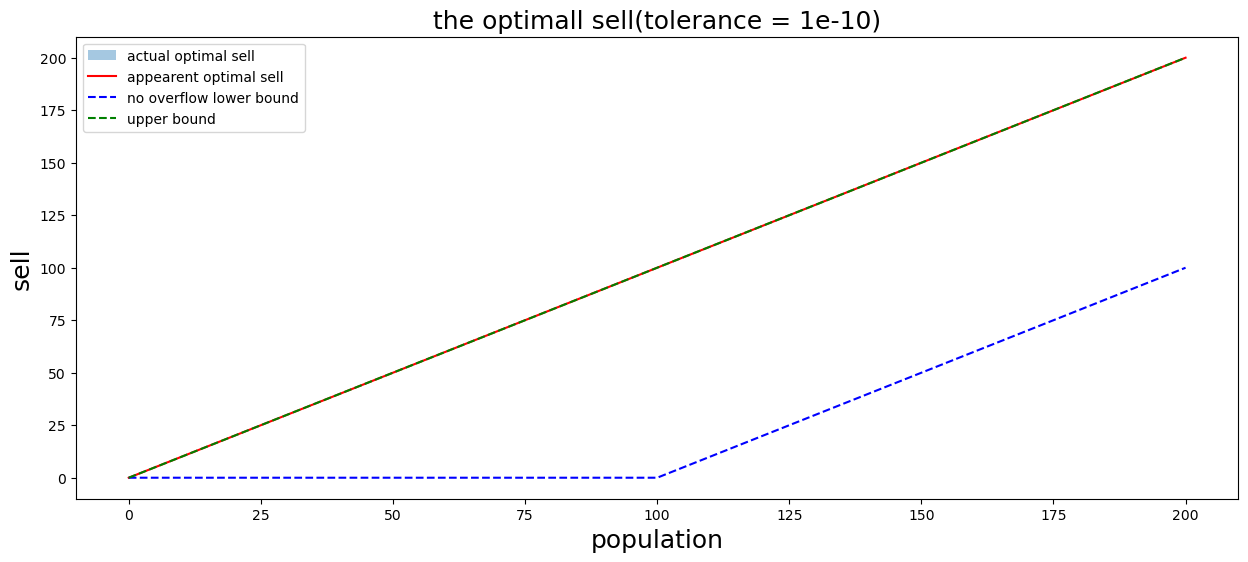

In [36]:
capacity = 200
significant_exact_iterative_method(10, 0.65)

100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


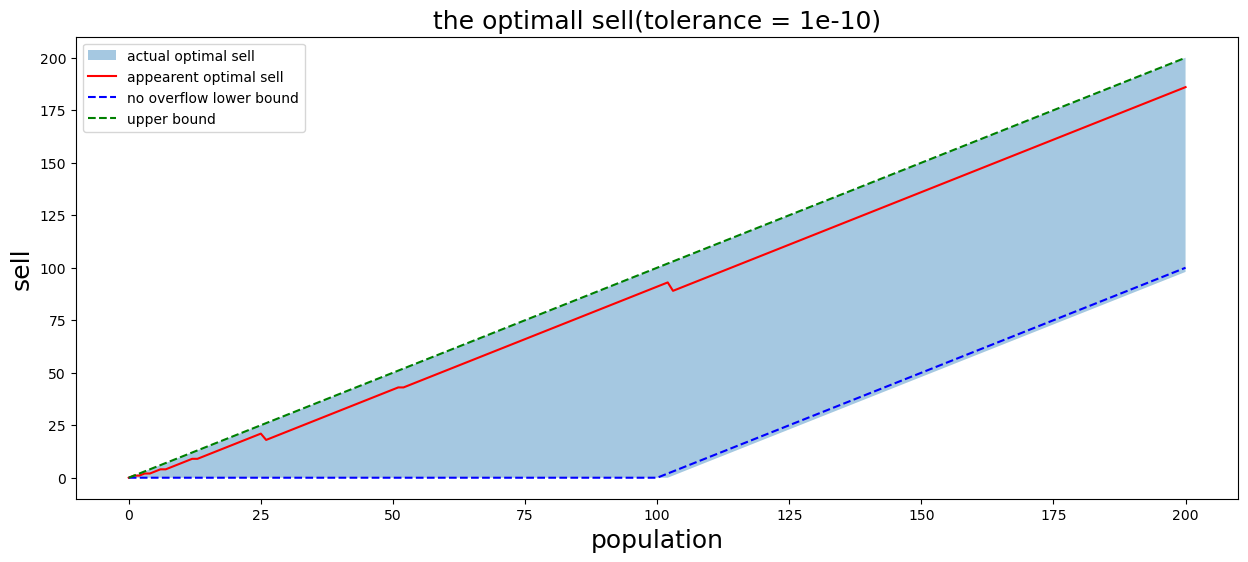

In [37]:
capacity = 200
significant_exact_iterative_method(10, gamma_treshold)

100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


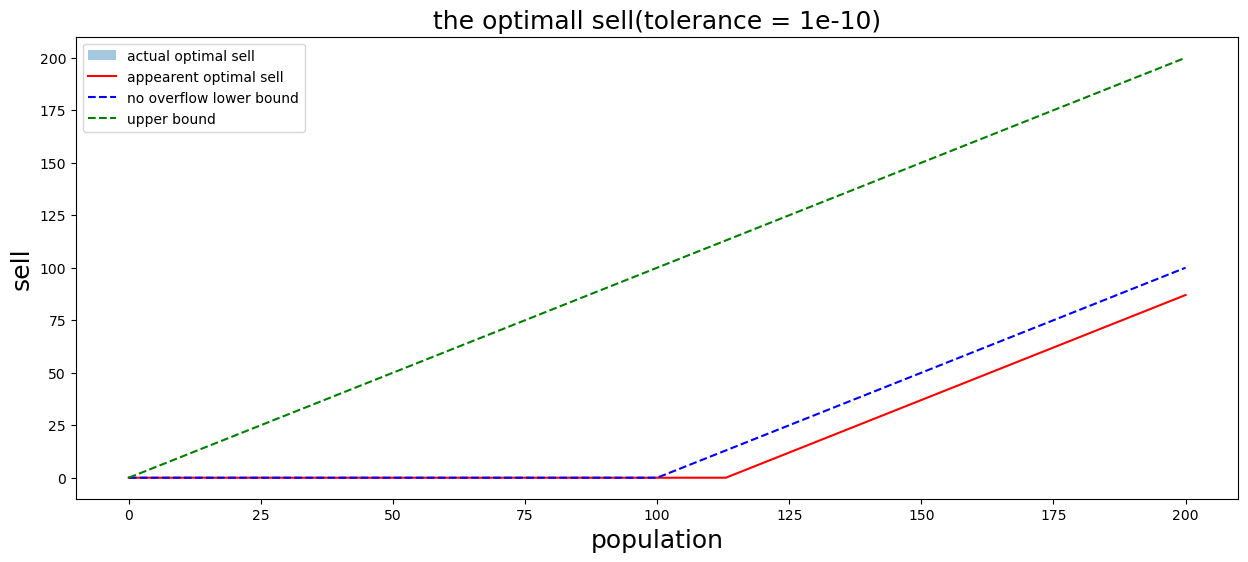

In [38]:
capacity = 200
significant_exact_iterative_method(10, 0.75)